Get dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../song_features.csv')
df.head()

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genres
0,0HZk0QsXPhMNAWNDR3rYE8,0.4700,0.364,0.378,0.0,7,0.3390,-7.381,0,0.0331,89.918,3,0.366,a-cappella
1,6tkbKjaHRL2ZG5wtmHzXgn,0.7640,0.556,0.412,0.0,7,0.0902,-10.224,1,0.0992,84.778,4,0.811,a-cappella
2,4z8sz6E4YyFuEkv5o7IJni,0.3020,0.497,0.312,0.0,11,0.0968,-9.088,0,0.0269,105.036,4,0.177,a-cappella
3,6XamqE26MOlAoXs1LZr8AU,0.3080,0.674,0.517,0.0,2,0.0896,-7.147,1,0.0555,120.127,4,0.476,a-cappella
4,5glU2EWqa5hpYqGPboSNjV,0.0243,0.419,0.817,0.0,2,0.2510,-4.704,1,0.0468,78.107,4,0.317,a-cappella


Heatmap to discover low correlation features

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
acousticness,1.000000,-0.421916,-0.784065,0.323526,-0.104296,-0.640456,-0.066722,-0.223505,-0.305464
danceability,-0.421916,1.000000,0.391948,-0.299802,0.001278,0.425349,0.228910,0.033849,0.533337
energy,-0.784065,0.391948,1.000000,-0.357118,0.194279,0.794030,0.085639,0.264318,0.448613
instrumentalness,0.323526,-0.299802,-0.357118,1.000000,-0.121329,-0.533992,-0.152479,-0.113529,-0.237620
liveness,-0.104296,0.001278,0.194279,-0.121329,1.000000,0.146228,0.129099,0.046717,0.069993
loudness,-0.640456,0.425349,0.794030,-0.533992,0.146228,1.000000,0.055282,0.222895,0.323491
speechiness,-0.066722,0.228910,0.085639,-0.152479,0.129099,0.055282,1.000000,0.040668,0.063647
tempo,-0.223505,0.033849,0.264318,-0.113529,0.046717,0.222895,0.040668,1.000000,0.153970
valence,-0.305464,0.533337,0.448613,-0.237620,0.069993,0.323491,0.063647,0.153970,1.000000


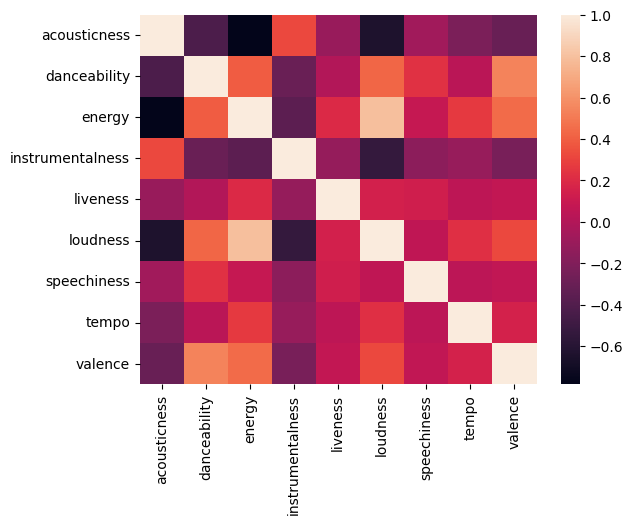

In [2]:
import seaborn as sns
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
dataplot = sns.heatmap(df[features].corr())
# List correlation values
df[features].corr()
# plt.show()

Investigate the relationship between energy and loudness since it has the highest correlation

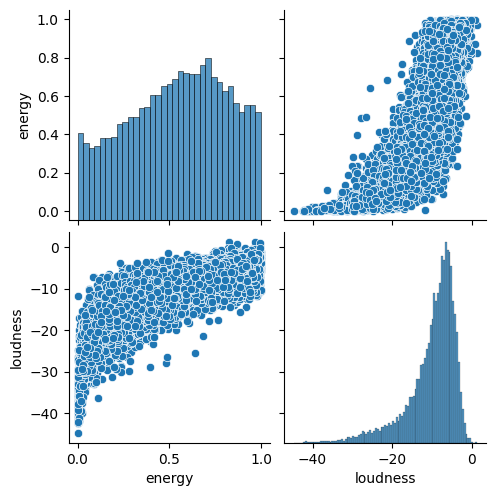

In [3]:
invest_features = ['energy', 'loudness']
data_scatter = sns.pairplot(df[invest_features])
plt.show()

Box plot for features

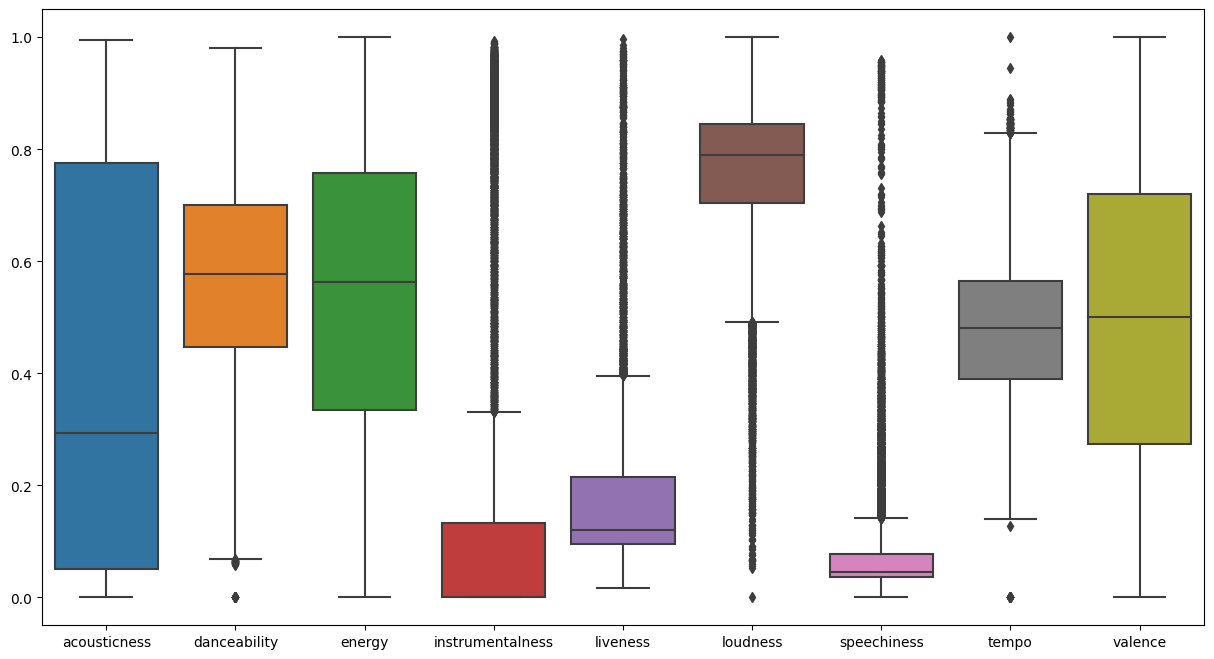

In [4]:

# Scale tempo and loudness to [0, 1]
for col in ['loudness', 'tempo']:
    df[col] = ((df[col] - df[col].min()) / (df[col].max() - df[col].min()))
sns.boxplot(data=df[features])
# Resize plot
plt.gcf().set_size_inches(15, 8)
plt.show()

Remove outliers

In [5]:
# Remove any data with tempo = 0
no_out_df = df[df['tempo'] != 0]
# Remove key, genres, id
no_out_df = no_out_df.drop(['key', 'genres', 'id'], axis=1)
# # One hot encoding mode and time_signature
# no_out_df = pd.get_dummies(no_out_df, columns=['mode', 'time_signature'])
# # Rename time_signature columns
# no_out_df = no_out_df.rename(columns={'time_signature_0': 'ts_0/4', 'time_signature_1': 'ts_1/4', 'time_signature_3': 'ts_3/4', 'time_signature_4': 'ts_4/4', 'time_signature_5': 'ts_5/4'})
no_out_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.4700,0.364,0.378,0.0,0.3390,0.810793,0,0.0331,0.369467,3,0.366
1,0.7640,0.556,0.412,0.0,0.0902,0.749127,1,0.0992,0.348347,4,0.811
2,0.3020,0.497,0.312,0.0,0.0968,0.773767,0,0.0269,0.431586,4,0.177
3,0.3080,0.674,0.517,0.0,0.0896,0.815869,1,0.0555,0.493594,4,0.476
4,0.0243,0.419,0.817,0.0,0.2510,0.868859,1,0.0468,0.320937,4,0.317


Clustering with Hierachical Clustering

In [6]:
import gower
from sklearn.cluster import AgglomerativeClustering
distance_matrix = gower.gower_matrix(no_out_df)
distance_matrix

array([[0.        , 0.23570882, 0.10272999, ..., 0.22120214, 0.15255977,
        0.12681091],
       [0.23570882, 0.        , 0.22416112, ..., 0.08681207, 0.20172848,
        0.17957945],
       [0.10272999, 0.22416112, 0.        , ..., 0.20405862, 0.13410255,
        0.17711964],
       ...,
       [0.22120214, 0.08681207, 0.20405862, ..., 0.        , 0.13199899,
        0.20395443],
       [0.15255977, 0.20172848, 0.13410255, ..., 0.13199899, 0.        ,
        0.13561182],
       [0.12681091, 0.17957945, 0.17711964, ..., 0.20395443, 0.13561182,
        0.        ]], dtype=float32)

In [7]:
model = AgglomerativeClustering(affinity='precomputed', linkage='complete')
clusters = model.fit(distance_matrix)

: 

: 

In [29]:
no_out_df['cluster'] = clusters.labels_
no_out_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode_0,mode_1,ts_0/4,ts_1/4,ts_3/4,ts_4/4,ts_5/4,cluster
0,0.4700,0.364,0.378,0.0,0.3390,0.810793,0.0331,0.369467,0.366,1,0,0,0,1,0,0,0
1,0.7640,0.556,0.412,0.0,0.0902,0.749127,0.0992,0.348347,0.811,0,1,0,0,0,1,0,0
2,0.3020,0.497,0.312,0.0,0.0968,0.773767,0.0269,0.431586,0.177,1,0,0,0,0,1,0,1
3,0.3080,0.674,0.517,0.0,0.0896,0.815869,0.0555,0.493594,0.476,0,1,0,0,0,1,0,0
4,0.0243,0.419,0.817,0.0,0.2510,0.868859,0.0468,0.320937,0.317,0,1,0,0,0,1,0,0


Investigate the clusters

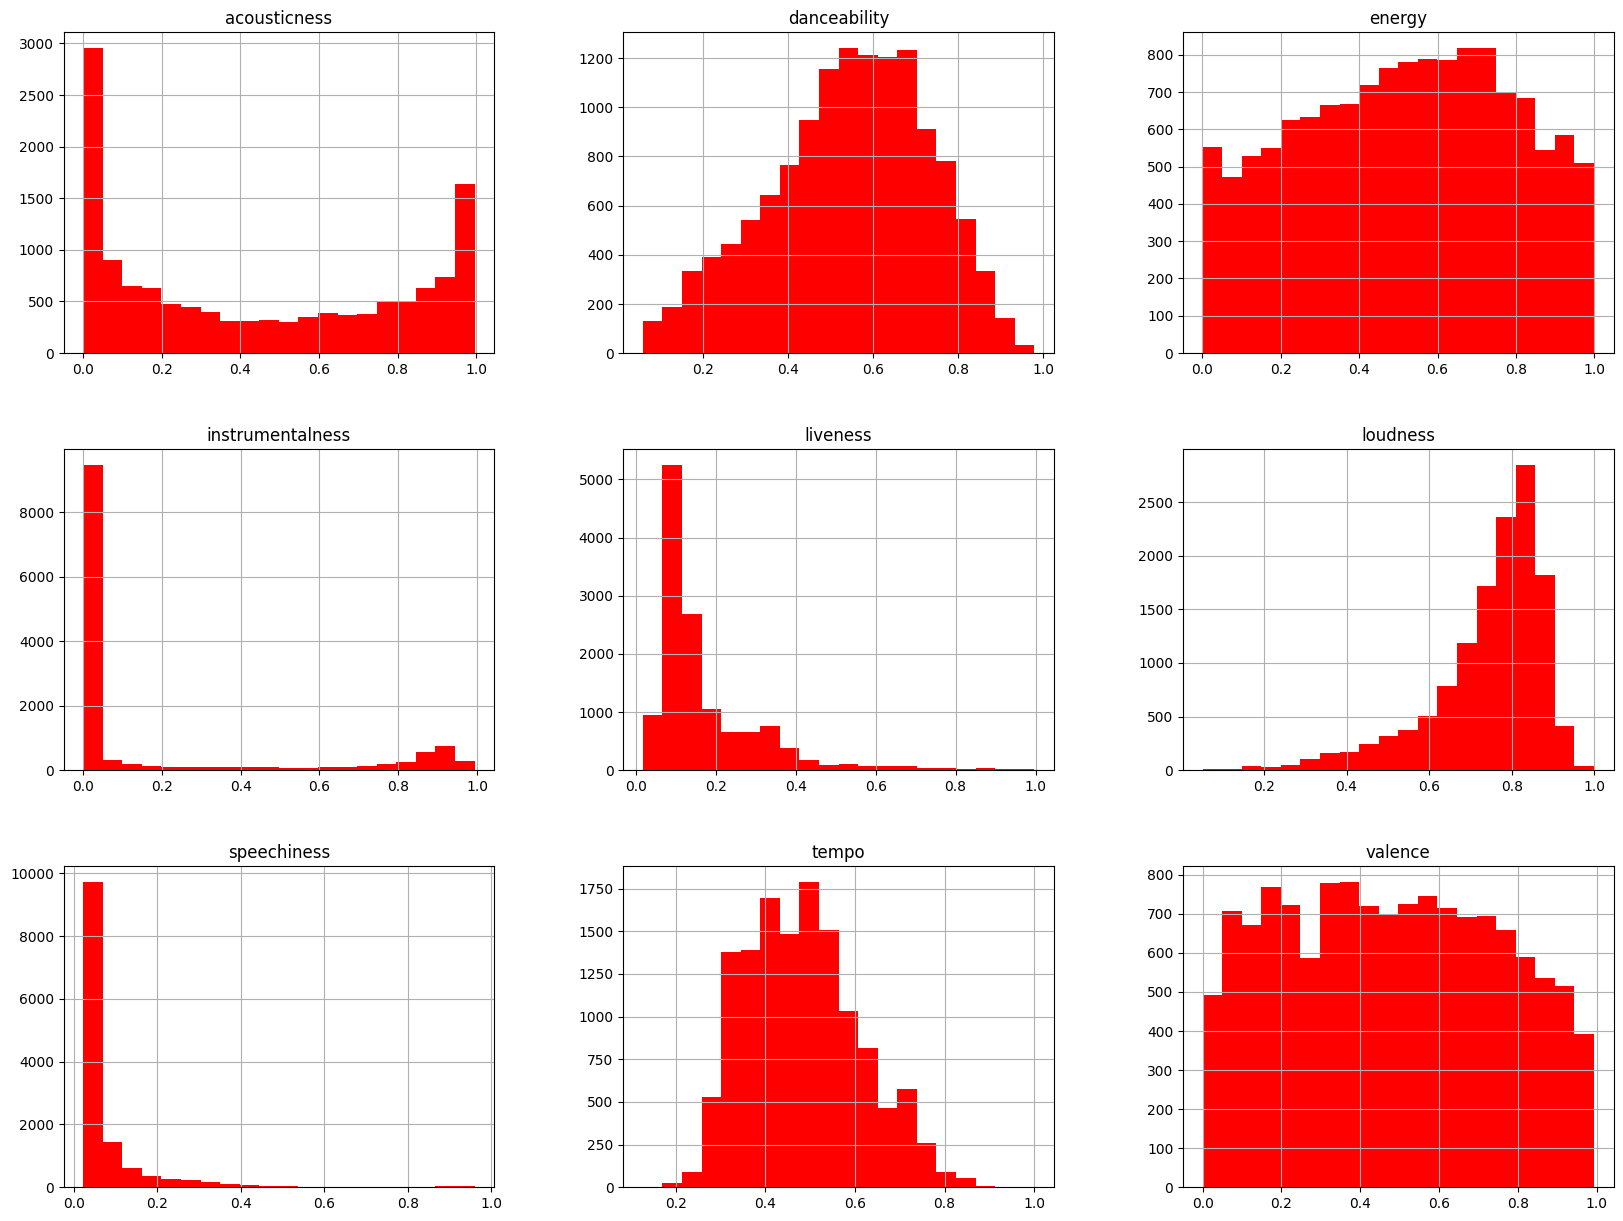

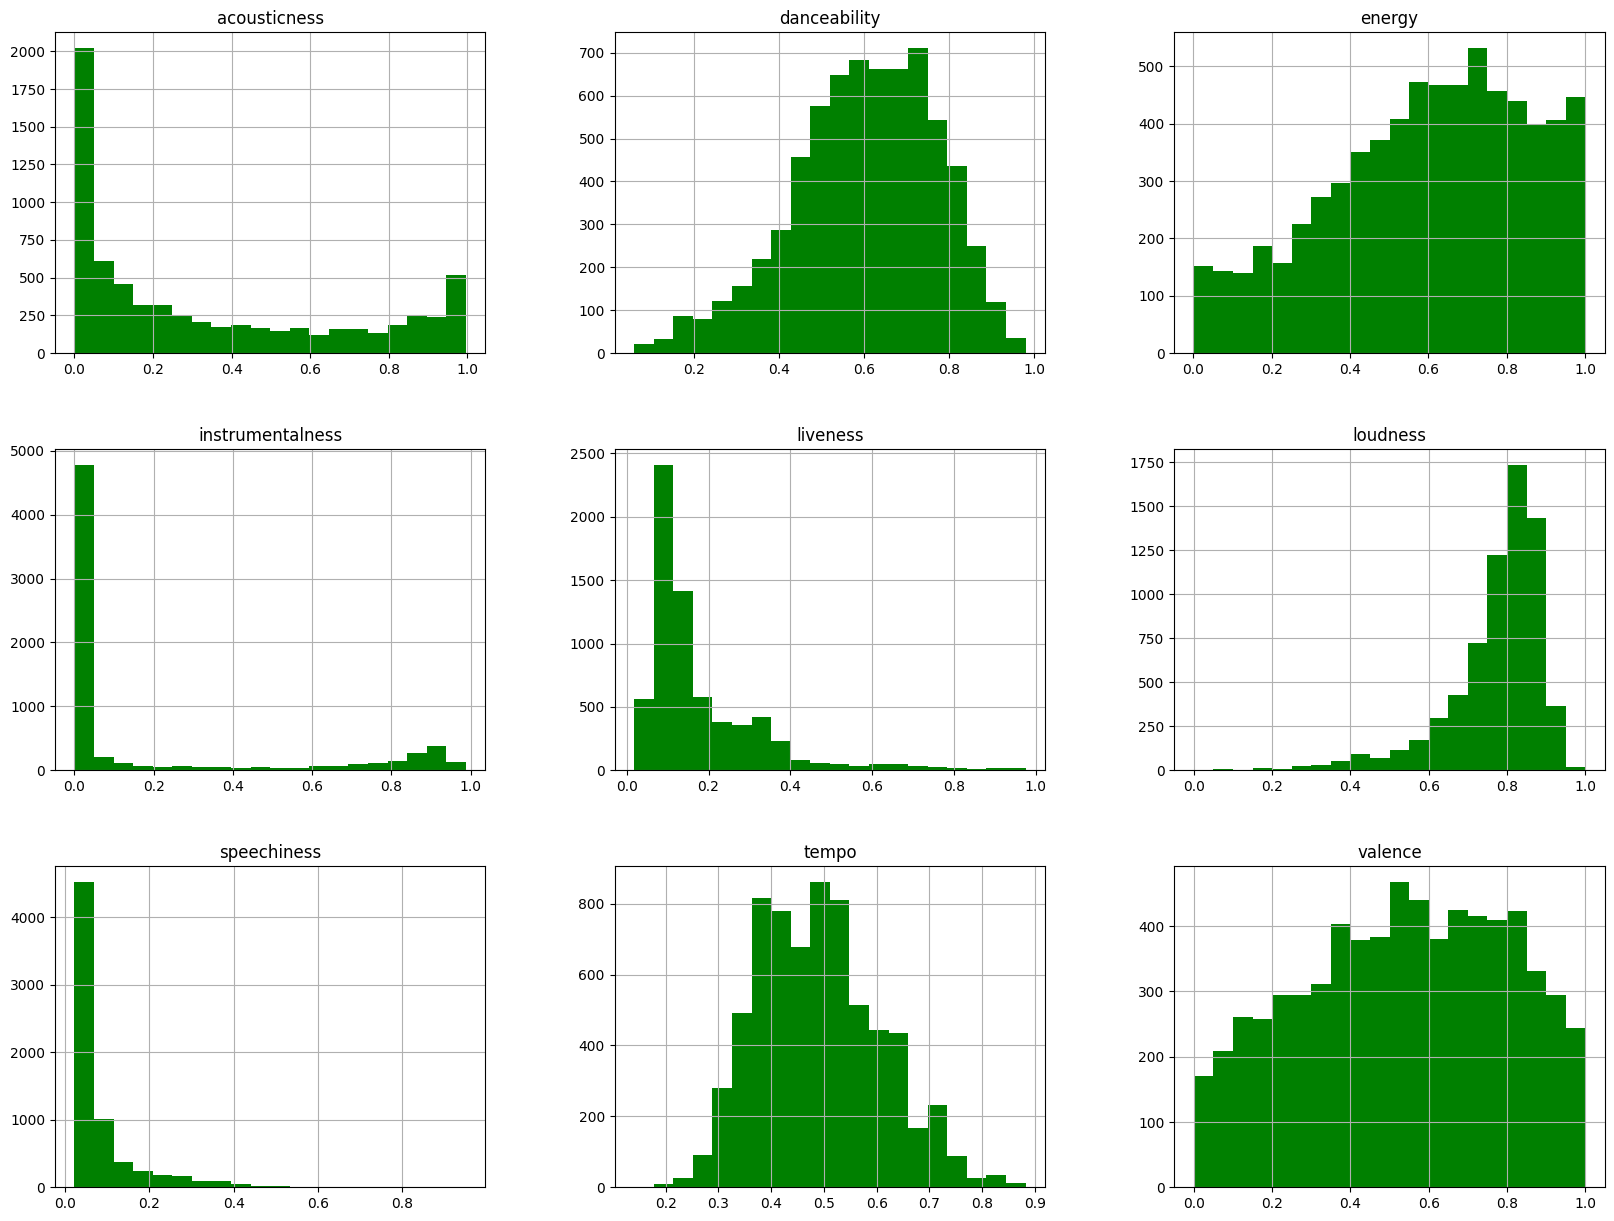

In [30]:
cluster1 = no_out_df[no_out_df['cluster'] == 0]
cluster2 = no_out_df[no_out_df['cluster'] == 1]
cluster1[features].hist(bins=20, figsize=(20, 15), color='red')
plt.show()
cluster2[features].hist(bins=20, figsize=(20, 15), color='green')
plt.show()

Investigate the difference between clusters

In [31]:
# TODO

Approach #2: Clustering using Gaussian Mixture Model